In [1]:
import os,sys,datetime
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from pathlib import Path
import collections
import numpy as np
import scipy
import pandas as pd
from sklearn.linear_model import LinearRegression
pd.options.display.max_columns=999
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
# # plt.rcParams['image.cmap'] = 'magma'
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
%matplotlib inline

import seaborn as sns # Used only to set up plots
sns.set_context(context = 'talk')
# sns.set_context(context='paper')
# plt.style.use('dark_background')
# plt.rcParams['figure.facecolor'] = '#272b30'
# plt.rcParams['image.cmap'] = 'viridis' 
#sys.path.append('/groups/turaga/home/turagas/research/')
%load_ext autoreload
%autoreload 2

In [2]:
pd.options.mode.chained_assignment = None
basepath=Path.home()/'Samuel_Susoy_mating/'
net=pd.read_csv(basepath/'synaptic_partners_v1.csv', skipinitialspace = True, quotechar = '"')
neuron_annot=pd.read_csv(basepath/'transmitters_and_annotations.csv',index_col=0)
# folder = basepath/'normalized_activity_id/'
folder = basepath/'normalized_activity_id_not_filtered/'
files = sorted(list(Path.iterdir(folder)))
data = [pd.read_csv(file,index_col=0) for file in files]
actcols = data[0].columns[:-12]
behcols = data[0].columns[-12:-1]
activity = [d[actcols] for d in data]
behavior = [d[behcols] for d in data]
files = [file.stem for file in files]
dataset_id = [d['dataset'][1] for d in data]
activity_list = ['HOA', 'HOB', 'PVZ', 'PCBL', 'PCCL', 'PCAL', 'SPCL', 'PVY', 'PVX',
       'PVV', 'PHCL', 'PLML', 'PHDL', 'VA10', 'VA11', 'AS11', 'VB11', 'EF1',
       'EF2', 'EF3', 'DVB', 'CP08', 'CA08', 'CA09', 'CP09', 'PVPR', 'R1AL',
       'R1BL', 'R2AL', 'R2BL', 'R6AL', 'R4AL', 'R3AL', 'PHAL', 'SPDL', 'VD13',
       'VD12', 'DB07', 'PDB', 'SPVL', 'VD11', 'DVA', 'VA12', 'DX1', 'DX2',
       'PDC', 'AS10', 'DA07', 'DD06', 'PHBL', 'R8BL', 'R9BL', 'PVPL', 'PVT']
behavior_list = ['Velocity', 'Rel.Velocity', 'Speed', 'Rel.Speed', 'TailAngle',
       'LtoTips', 'LtoVul', 'Spicules', 'pos_x', 'pos_y', 'PostSperm']
for bev_df in behavior:
    bev_df.loc[:,bev_df.columns != 'PostSperm'] = (bev_df.loc[:,bev_df.columns != 'PostSperm'] - bev_df.loc[:,bev_df.columns != 'PostSperm'].mean())/(bev_df.loc[:,bev_df.columns != 'PostSperm'].std())
    

In [3]:
torch.manual_seed(1)

class Net(torch.nn.Module):
    def __init__ (self, n_feature, n_output):
        """
        Single Layer Linear Neural Network
        """
        super(Net, self).__init__()
        self.linear = torch.nn.Linear(n_feature, n_output)
        self.n_feature = n_feature
        self.n_output = n_output
        
    def weighted_MSELoss(self,out_data, target_data, missing_data):
        loss = 0.5*torch.mean(-(missing_data - 1)*(out_data - target_data)**2)
        return loss
    
    def __MSELoss(self, out_data, target_data):
        loss = 0.5*torch.mean((out_data - target_data)**2)
        return loss
    
    def forward(self, x):
        return self.linear(x)      
    
    def predict(self, in_data, missing_in, missing_out, target_data):
        """
        Predict using trained network assuming missing output data.
        
        Parameters:
        in_data, out_dim
        missing_in - matrix of missing input_data values
        
        Returns:
        
        prediction values in tensor form
        """
        out_data = torch.zeros(in_data.shape[0], self.n_output)
        input_array = np.concatenate((in_data,missing_in),1) 
        miss_out_tensor = torch.from_numpy(missing_out).unsqueeze(0).to(torch.float32).cuda()
        target_tensor = torch.from_numpy(target_data).unsqueeze(0).to(torch.float32).cuda()
        loss_sum = 0
        for image in range(in_data.shape[0]):
            in_tensor = torch.from_numpy(input_array[image,:]).unsqueeze(0).to(torch.float32).cuda()
            output = self.forward(in_tensor)
            out_data[image,:] = output
            loss_sum += self.weighted_MSELoss(output, target_tensor[:,image,:], miss_out_tensor[:,image,:])
        loss = loss_sum/(in_data.shape[0])
        return out_data, loss


In [4]:
class Scale_Net(torch.nn.Module):
    def __init__(self, n_feature, stdev, mean):
            super(Scale_Net, self).__init__()
            self.n_feature = n_feature
            self.scale = torch.from_numpy(stdev).unsqueeze(0).to(torch.float32)
            self.bias = torch.from_numpy(mean).unsqueeze(0).to(torch.float32)
            self.scale = torch.nn.Parameter(self.scale)
            self.bias = torch.nn.Parameter(self.bias)
            
    def forward(self,x):
            return (x - self.bias)/self.scale
        
    def predict(self, in_data):
            out_data = torch.zeros(in_data.shape[0], self.n_feature)
            for image in range(in_data.shape[0]):
                in_tensor = torch.from_numpy(in_data[image,:]).unsqueeze(0).to(torch.float32).cuda()
                output = self.forward(in_tensor)
                out_data[image,:] = output
            return out_data
           
            

In [5]:
def train(decoder, train_act_list, missing_act_list, train_bev_list, missing_bev_list, learning_rate, epochs, batch_size):
        loss_list = []
        criterion = decoder.weighted_MSELoss
        for epoch in range(epochs):
            loss_sum = 0
            for j in range(len(train_act_list)):
                optimizer = torch.optim.Adam(decoder.parameters(), lr = learning_rate)
                neuron_in_tensor = torch.from_numpy(train_act_list[j]).unsqueeze(0).to(torch.float32).cuda()
                target = torch.from_numpy(train_bev_list[j]).unsqueeze(0).to(torch.float32).cuda()
                missing_in_tensor = torch.from_numpy(missing_act_list[j]).unsqueeze(0).to(torch.float32).cuda()
                missing_out_tensor = torch.from_numpy(missing_bev_list[j]).unsqueeze(0).to(torch.float32).cuda()
                batch_num = int(neuron_in_tensor.shape[1]/batch_size)
                for i in range(batch_num):
                    optimizer.zero_grad()
                    if i < batch_num - 1:
                        cat_input = torch.cat((neuron_in_tensor[:,i*batch_size:(i+1)*batch_size,:], missing_in_tensor[:, i*batch_size:(i+1)*batch_size,:]),2)
                        output = decoder.forward(cat_input)
                        loss = criterion(output,target[:,i*batch_size:(i+1)*batch_size,:],missing_out_tensor[:,i*batch_size:(i+1)*batch_size,:])
                    else:
                        cat_input = torch.cat((neuron_in_tensor[:,i*batch_size:,:], missing_in_tensor[:, i*batch_size:,:]),2)
                        output = decoder.forward(cat_input)
                        loss = criterion(output,target[:,i*batch_size:,:],missing_out_tensor[:,i*batch_size:,:])
                    loss.backward()
                    optimizer.step()
                    loss_sum += loss.item()
            epoch_loss = loss_sum/(len(train_act_list)*batch_num)
            loss_list.append(epoch_loss)
        return loss_list

def dtrain(decoder, train_scale_list, train_act_list, missing_act_list, train_bev_list, missing_bev_list, learning_rate, epochs, batch_size):
        loss_list = []
        criterion = decoder.weighted_MSELoss
        for epoch in range(epochs):
#             if epoch % 1000 == 0:
#                 print("Working on epoch number: " + str(epoch))
            loss_sum = 0
            for j in range(len(train_act_list)):
                params = list(decoder.parameters()) + list(train_scale_list[j].parameters())
                optimizer = torch.optim.Adam(params, lr = learning_rate)
                neuron_in_tensor = torch.from_numpy(train_act_list[j]).unsqueeze(0).to(torch.float32).cuda()
                target = torch.from_numpy(train_bev_list[j]).unsqueeze(0).to(torch.float32).cuda()
                missing_in_tensor = torch.from_numpy(missing_act_list[j]).unsqueeze(0).to(torch.float32).cuda()
                missing_out_tensor = torch.from_numpy(missing_bev_list[j]).unsqueeze(0).to(torch.float32).cuda()
                batch_num = int(neuron_in_tensor.shape[1]/batch_size)
                for i in range(batch_num):
                    optimizer.zero_grad()
                    if i < batch_num - 1:
                        scaled_input = train_scale_list[j].forward(neuron_in_tensor[:,i*batch_size:(i+1)*batch_size,:])
                        scaled_miss_input = torch.cat((scaled_input, missing_in_tensor[:, i*batch_size:(i+1)*batch_size,:]),2)
                        output = decoder.forward(scaled_miss_input)
                        loss = criterion(output,target[:,i*batch_size:(i+1)*batch_size,:],missing_out_tensor[:,i*batch_size:(i+1)*batch_size,:])
                    else:
                        scaled_input = train_scale_list[j].forward(neuron_in_tensor[:,i*batch_size:,:])
                        scaled_miss_input = torch.cat((scaled_input, missing_in_tensor[:, i*batch_size:,:]),2)
                        output = decoder.forward(scaled_miss_input)
                        loss = criterion(output,target[:,i*batch_size:,:],missing_out_tensor[:,i*batch_size:,:])
                    loss.backward()
                    optimizer.step()
                    loss_sum += loss.item()
            epoch_loss = loss_sum/(len(train_act_list)*batch_num)
            loss_list.append(epoch_loss)
        return loss_list         
        
def scale_train(decoder, test_scale_list, test_act_list, test_missing_act_list, test_bev_list, test_missing_bev_list, learning_rate, epochs, batch_size):
    loss_list = []
    criterion = decoder.weighted_MSELoss
    for epoch in range(epochs):
#             if epoch % 1000 == 0:
#                 print("Working on epoch number: " + str(epoch))
            loss_sum = 0
            for j in range(len(test_act_list)):
                optimizer = torch.optim.Adam(test_scale_list[j].parameters(), lr = learning_rate)
                neuron_in_tensor = torch.from_numpy(test_act_list[j]).unsqueeze(0).to(torch.float32).cuda()
                target = torch.from_numpy(test_bev_list[j]).unsqueeze(0).to(torch.float32).cuda()
                missing_in_tensor = torch.from_numpy(test_missing_act_list[j]).unsqueeze(0).to(torch.float32).cuda()
                missing_out_tensor = torch.from_numpy(test_missing_bev_list[j]).unsqueeze(0).to(torch.float32).cuda()
                batch_num = int(neuron_in_tensor.shape[1]/batch_size)
                for i in range(batch_num):
                    optimizer.zero_grad()
                    if i < int(neuron_in_tensor.shape[1]/batch_size):
                        scaled_input = test_scale_list[j].forward(neuron_in_tensor[:,i*batch_size:(i+1)*batch_size,:])
                        scaled_miss_input = torch.cat((scaled_input, missing_in_tensor[:, i*batch_size:(i+1)*batch_size,:]),2)
                        output = decoder.forward(scaled_miss_input)
                        loss = criterion(output,target[:,i*batch_size:(i+1)*batch_size,:],missing_out_tensor[:,i*batch_size:(i+1)*batch_size,:])
                    else:
                        scaled_input = test_scale_list[j].forward(neuron_in_tensor[:,i*batch_size:,:])
                        scaled_miss_input = torch.cat((scaled_input, missing_in_tensor[:, i*batch_size:,:]),2)
                        output = decoder.forward(scaled_miss_input)
                        loss = criterion(output,target[:,i*batch_size:,:],missing_out_tensor[:,i*batch_size:,:])
                    loss.backward()
                    optimizer.step()
                    loss_sum += loss.item()
            epoch_loss = loss_sum/(len(test_act_list)*batch_num)
            loss_list.append(epoch_loss)
    return loss_list


In [6]:
prediction_list, groundtruth_list, loss_list, weight_list = [], [], [], []
for i in range(5):
    trainlist = [0,1,2,3,4,5,6]
    print("Training Decoding Network and Scaling Network Together on Training Data. Testing on worms: " + str(i) + ', ' + str(i+1))
    trainlist.remove(i)
    trainlist.remove(i+1)
    train_act_list, test_act_list = [activity[i] for i in trainlist], [activity[i] for i in [i,i+1]]
    train_bev_list, test_bev_list = [behavior[i] for i in trainlist], [behavior[i] for i in [i,i+1]]
    train_act_matrix_list = [df.values for df in train_act_list]  # list of matrices that contain calcium activity for each neuron on the 5 training worms
    train_bev_matrix_list = [df.values for df in train_bev_list] # list of matrices that contain behavior data on the 5 training worms
    test_act_matrix_list = [df.values for df in test_act_list] # list of matrices that contain calcium activity for each neuron on the 2 test worms
    test_bev_matrix_list = [df.values for df in test_bev_list] # list of matrices that contain behavior data on the 2 test worms
    miss_act_list, miss_bev_list = [], [] # lists of matrices that store missing data for activity and behavior of training data
    test_miss_act_list, test_miss_bev_list = [], [] # lists of matrices that store missing data for activity and behavior of test data
    
    for i in range(len(train_act_list)):
        act_matrix, bev_matrix = train_act_matrix_list[i], train_bev_matrix_list[i]  
        miss_act, miss_bev = np.zeros(act_matrix.shape), np.zeros(bev_matrix.shape)
        miss_act[np.isnan(act_matrix)], miss_bev[np.isnan(bev_matrix)] = 1,1
        train_act_matrix_list[i][np.isnan(act_matrix)], train_bev_matrix_list[i][np.isnan(bev_matrix)] = 0,0
        miss_act_list.append(miss_act)
        miss_bev_list.append(miss_bev)

    for i in range(len(test_act_list)):
        test_act_matrix, test_bev_matrix = test_act_matrix_list[i], test_bev_matrix_list[i]
        test_miss_act, test_miss_bev = np.zeros(test_act_matrix.shape), np.zeros(test_bev_matrix.shape)
        test_miss_act[np.isnan(test_act_matrix)], test_miss_bev[np.isnan(test_bev_matrix)] = 1,1
        test_act_matrix_list[i][np.isnan(test_act_matrix)], test_bev_matrix_list[i][np.isnan(test_bev_matrix)] = 0,0
        test_miss_act_list.append(test_miss_act)
        test_miss_bev_list.append(test_miss_bev)

    N, T, O = act_matrix.shape[1], act_matrix.shape[0], bev_matrix.shape[1]  
    
    train_scalenet_list = []
    test_scalenet_list = []
    for in_data in train_act_list:
         worm_scaler = Scale_Net(N, np.ones(N), np.zeros(N))
         worm_scaler.cuda()
         train_scalenet_list.append(worm_scaler)
        
    for in_data in test_act_list:
         worm_scaler = Scale_Net(N, np.ones(N), np.zeros(N))
         worm_scaler.cuda()
         test_scalenet_list.append(worm_scaler)   
    
    epochs = 300
    output = np.ndarray(shape = bev_matrix.shape)
    decode_net = Net(n_feature = 2*N, n_output = O).cuda() 
    loss = dtrain(decode_net, train_scalenet_list, train_act_matrix_list, miss_act_list, train_bev_matrix_list, miss_bev_list, learning_rate = 1e-4, epochs = epochs, batch_size = 128)
    decode_weights = [p.detach().cpu().numpy() for p in decode_net.parameters()]
    weight_list.append(decode_weights)
    loss_list.append(loss)
    scale_train(decode_net, test_scalenet_list, test_act_matrix_list, test_miss_act_list, test_bev_matrix_list, test_miss_bev_list, learning_rate = 1e-4, epochs = epochs, batch_size = 128)
    
    worm0_scale = test_scalenet_list[0].predict(test_act_matrix_list[0])
    worm0_output, test0_loss = decode_net.predict(worm0_scale.data.numpy(), test_miss_act_list[0], test_miss_bev_list[0], test_bev_matrix_list[0])
    
    worm1_scale = test_scalenet_list[1].predict(test_act_matrix_list[1])
    worm1_output, test1_loss = decode_net.predict(worm1_scale.data.numpy(), test_miss_act_list[1], test_miss_bev_list[1], test_bev_matrix_list[1])
    
    predict_data = np.concatenate((worm0_output.data.numpy(), worm1_output.data.numpy()), axis = 0)
    predict_df = pd.DataFrame(predict_data, columns = behavior_list)
    ground_truth_data = np.concatenate((test_bev_list[0].values, test_bev_list[1].values), axis = 0)
    groundtruth_df = pd.DataFrame(ground_truth_data, columns = behavior_list)
    prediction_list.append(predict_df)
    groundtruth_list.append(groundtruth_df)
    print("worm0 loss: ", test0_loss.data)
    print("worm1 loss: ", test1_loss.data)
    #print("worm0 scaling factor: ", test_scalenet_list[0].scale, " bias: ", test_scalenet_list[0].bias)
    #print("worm1 scaling factor: ", test_scalenet_list[1].scale, " bias: ", test_scalenet_list[1].bias)
    

Training Decoding Network and Scaling Network Together on Training Data. Testing on worms: 0, 1
worm0 loss:  tensor(0.4300, device='cuda:0')
worm1 loss:  tensor(0.4729, device='cuda:0')
Training Decoding Network and Scaling Network Together on Training Data. Testing on worms: 1, 2
worm0 loss:  tensor(0.5159, device='cuda:0')
worm1 loss:  tensor(1.2920, device='cuda:0')
Training Decoding Network and Scaling Network Together on Training Data. Testing on worms: 2, 3
worm0 loss:  tensor(1.2548, device='cuda:0')
worm1 loss:  tensor(0.6662, device='cuda:0')
Training Decoding Network and Scaling Network Together on Training Data. Testing on worms: 3, 4
worm0 loss:  tensor(0.7986, device='cuda:0')
worm1 loss:  tensor(0.5136, device='cuda:0')
Training Decoding Network and Scaling Network Together on Training Data. Testing on worms: 4, 5
worm0 loss:  tensor(0.6111, device='cuda:0')
worm1 loss:  tensor(0.5706, device='cuda:0')


In [7]:
for act_df in activity:
    act_df.loc[:, act_df.columns] =  (act_df.loc[:, act_df.columns] -  act_df.loc[:, act_df.columns].mean())/ act_df.loc[:, act_df.columns].std()
    
prediction_list_z, groundtruth_list_z, loss_list_z, weight_list_z = [], [], [], []    
for i in range(5):
    trainlist = [0,1,2,3,4,5,6]
    print("Training Decoding Network Training Data. Testing on worms: " + str(i) + ', ' + str(i+1))
    trainlist.remove(i)
    trainlist.remove(i+1)
    train_act_list, test_act_list = [activity[i] for i in trainlist], [activity[i] for i in [i,i+1]]
    train_bev_list, test_bev_list = [behavior[i] for i in trainlist],[behavior[i] for i in [i,i+1]]
    train_act_matrix_list = [df.values for df in train_act_list]  # list of matrices that contain calcium activity for each neuron on the 5 training worms
    train_bev_matrix_list = [df.values for df in train_bev_list] # list of matrices that contain behavior data on the 5 training worms
    test_act_matrix_list = [df.values for df in test_act_list] # list of matrices that contain calcium activity for each neuron on the 2 test worms
    test_bev_matrix_list = [df.values for df in test_bev_list] # list of matrices that contain behavior data on the 2 test worms
    miss_act_list, miss_bev_list = [], [] # lists of matrices that store missing data for activity and behavior of training data
    test_miss_act_list, test_miss_bev_list = [], [] # lists of matrices that store missing data for activity and behavior of test data
    
    for i in range(len(train_act_list)):
        act_matrix, bev_matrix = train_act_matrix_list[i], train_bev_matrix_list[i]  
        miss_act, miss_bev = np.zeros(act_matrix.shape), np.zeros(bev_matrix.shape)
        miss_act[np.isnan(act_matrix)], miss_bev[np.isnan(bev_matrix)] = 1,1
        train_act_matrix_list[i][np.isnan(act_matrix)], train_bev_matrix_list[i][np.isnan(bev_matrix)] = 0,0
        miss_act_list.append(miss_act)
        miss_bev_list.append(miss_bev)

    for i in range(len(test_act_list)):
        test_act_matrix, test_bev_matrix = test_act_matrix_list[i], test_bev_matrix_list[i]
        test_miss_act, test_miss_bev = np.zeros(test_act_matrix.shape), np.zeros(test_bev_matrix.shape)
        test_miss_act[np.isnan(test_act_matrix)], test_miss_bev[np.isnan(test_bev_matrix)] = 1,1
        test_act_matrix_list[i][np.isnan(test_act_matrix)], test_bev_matrix_list[i][np.isnan(test_bev_matrix)] = 0,0
        test_miss_act_list.append(test_miss_act)
        test_miss_bev_list.append(test_miss_bev)

    N, T, O = act_matrix.shape[1], act_matrix.shape[0], bev_matrix.shape[1] 
    
    epochs = 300
    decode_net = Net(n_feature = 2*N, n_output = O)
    decode_net.cuda()
    decode_loss = train(decode_net, train_act_matrix_list, miss_act_list, train_bev_matrix_list, miss_bev_list, 1e-4, epochs, batch_size = 128)
    decode_weights = [p.detach().cpu().numpy() for p in decode_net.parameters()]
    weight_list_z.append(decode_weights)
    loss_list_z.append(loss)    
    
    worm0_output, test0_loss = decode_net.predict(test_act_matrix_list[0], test_miss_act_list[0], test_miss_bev_list[0], test_bev_matrix_list[0])
    worm1_output, test1_loss = decode_net.predict(test_act_matrix_list[1], test_miss_act_list[1], test_miss_bev_list[1], test_bev_matrix_list[1])
    predict_data = np.concatenate((worm0_output.data.numpy(), worm1_output.data.numpy()), axis = 0)
    predict_df = pd.DataFrame(predict_data, columns = behavior_list)
    ground_truth_data = np.concatenate((test_bev_list[0].values, test_bev_list[1].values), axis = 0)
    groundtruth_df = pd.DataFrame(ground_truth_data, columns = behavior_list)
    prediction_list_z.append(predict_df)
    groundtruth_list_z.append(groundtruth_df)
    print("worm0 loss: ", test0_loss.data)
    print("worm1 loss: ", test1_loss.data)   

Training Decoding Network Training Data. Testing on worms: 0, 1
worm0 loss:  tensor(0.3930, device='cuda:0')
worm1 loss:  tensor(0.3371, device='cuda:0')
Training Decoding Network Training Data. Testing on worms: 1, 2
worm0 loss:  tensor(0.3315, device='cuda:0')
worm1 loss:  tensor(0.3536, device='cuda:0')
Training Decoding Network Training Data. Testing on worms: 2, 3
worm0 loss:  tensor(0.3653, device='cuda:0')
worm1 loss:  tensor(0.3985, device='cuda:0')
Training Decoding Network Training Data. Testing on worms: 3, 4
worm0 loss:  tensor(0.3921, device='cuda:0')
worm1 loss:  tensor(0.3366, device='cuda:0')
Training Decoding Network Training Data. Testing on worms: 4, 5
worm0 loss:  tensor(0.3268, device='cuda:0')
worm1 loss:  tensor(0.4327, device='cuda:0')


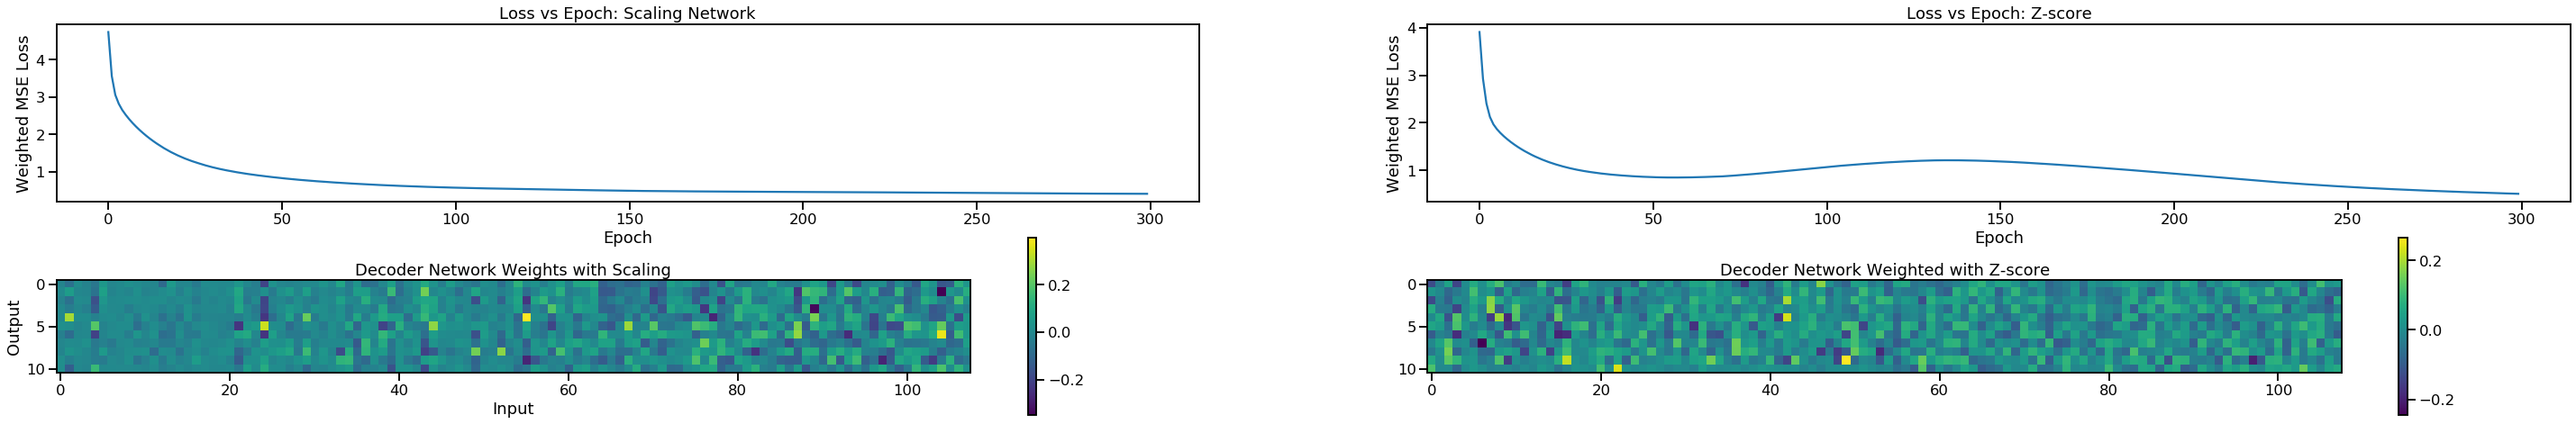

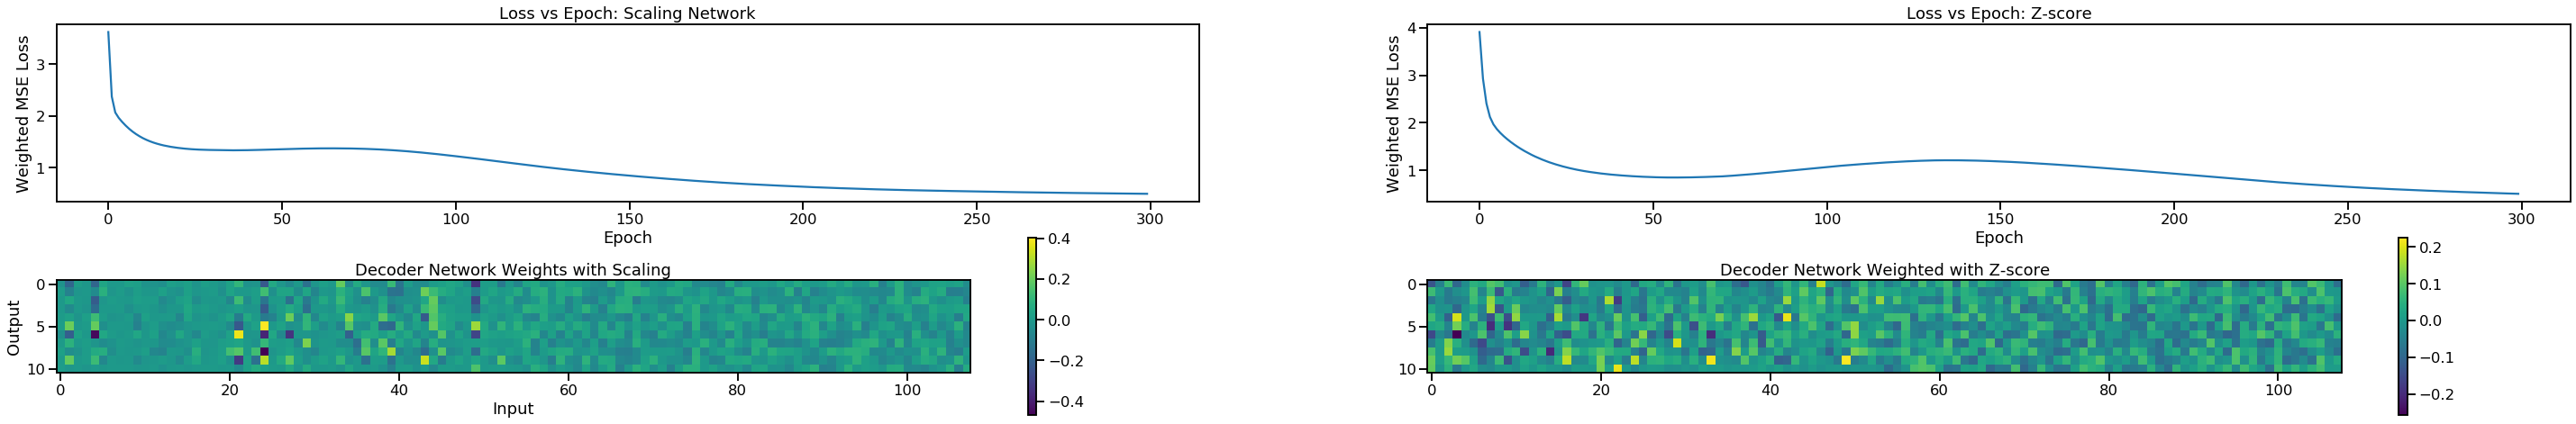

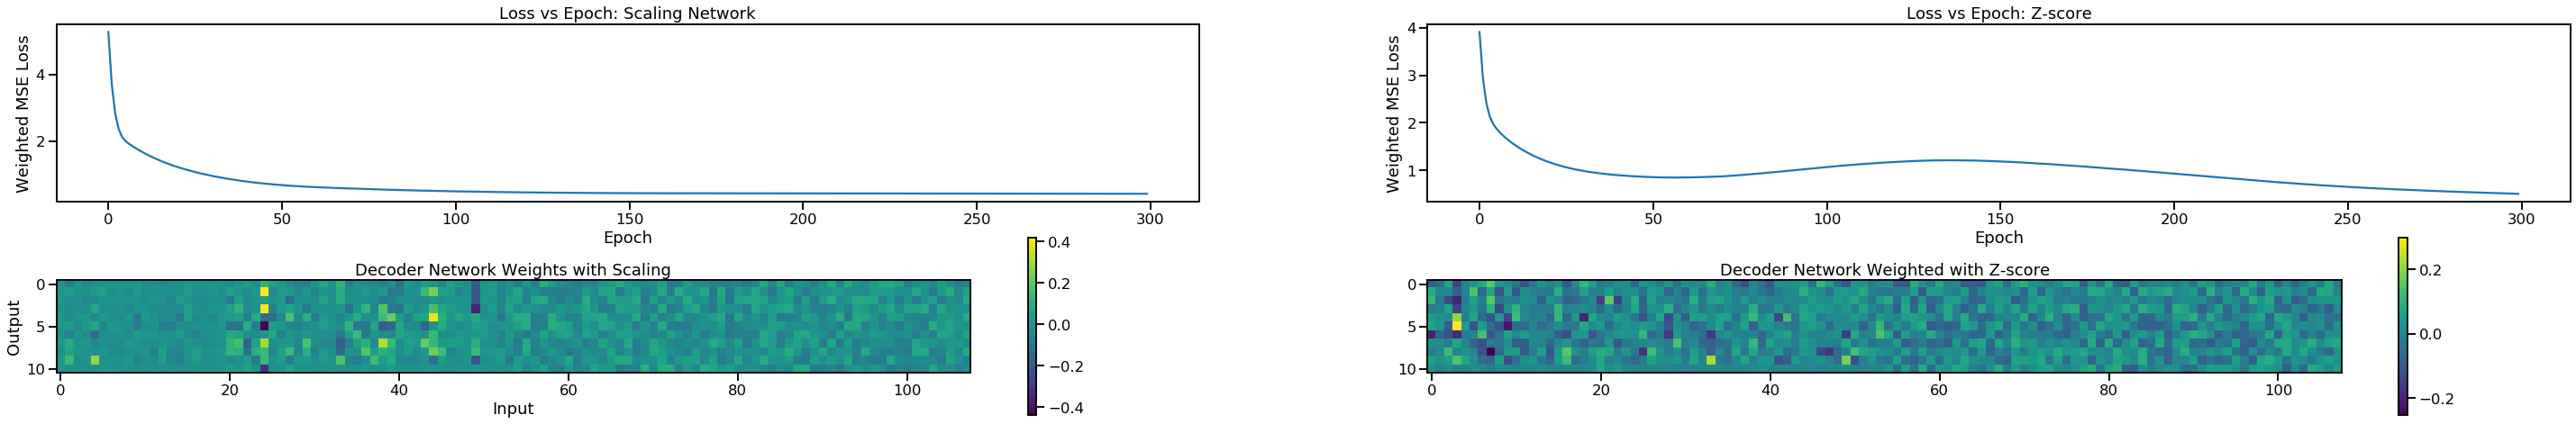

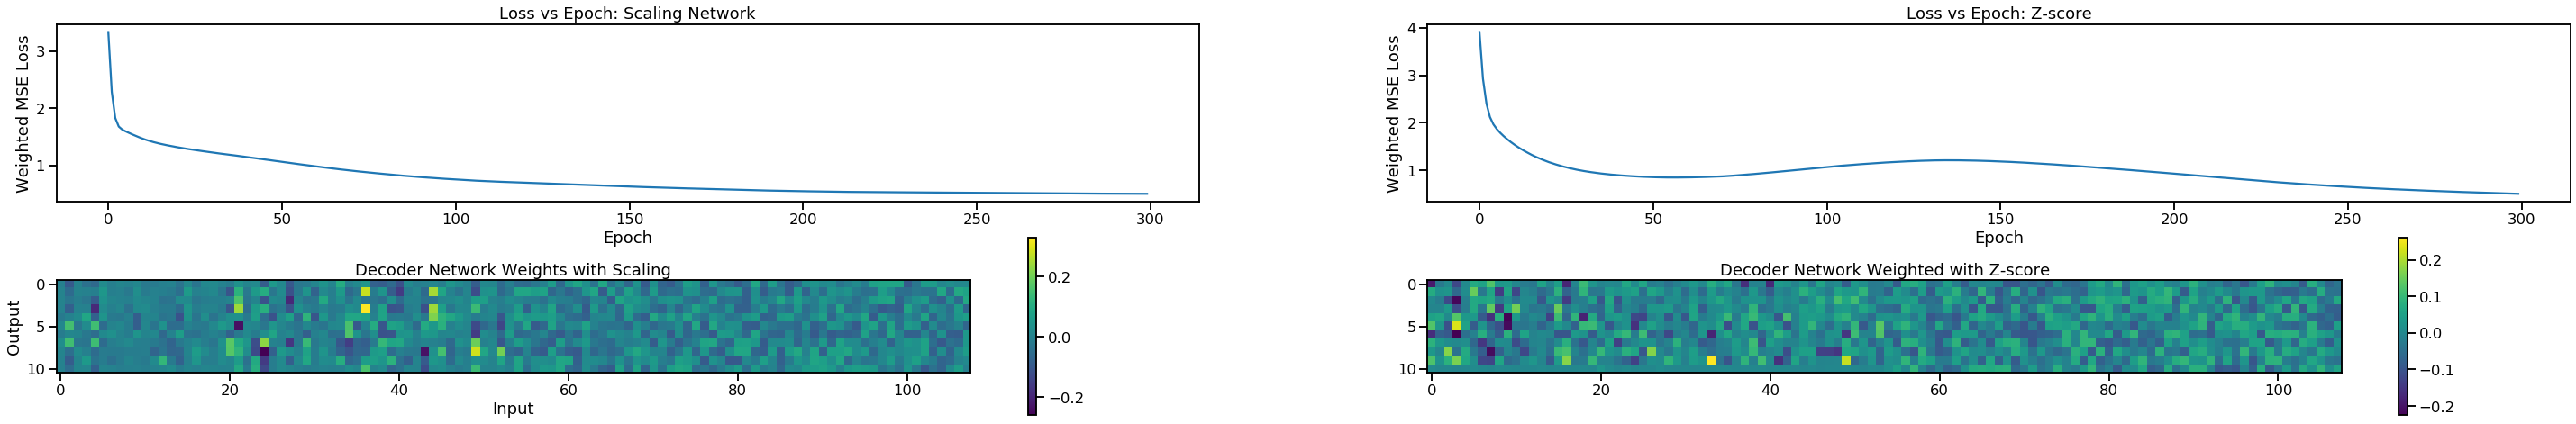

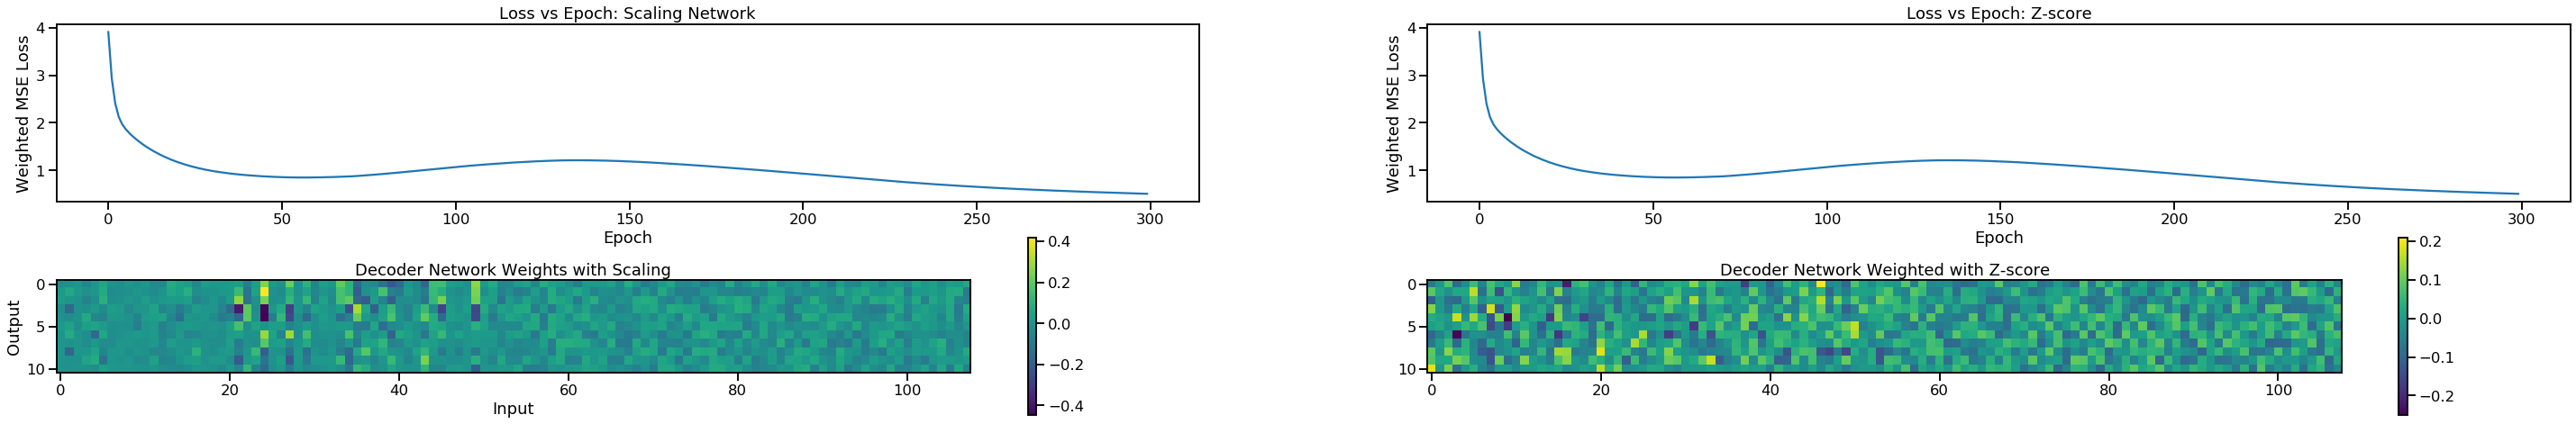

In [8]:
for i in range(5):
    f,axes = plt.subplots(2,2, figsize=(50,8))
    axes[0,0].set_title('Loss vs Epoch: Scaling Network')
    axes[0,0].plot(loss_list[i])
    axes[0,0].set_ylabel('Weighted MSE Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[1,0].set_title('Decoder Network Weights with Scaling')
    im = axes[1,0].imshow(weight_list[i][0])
    f.colorbar(im, ax = axes[1,0])
    axes[1,0].set_ylabel('Output')
    axes[1,0].set_xlabel('Input')
    axes[0,1].set_title('Loss vs Epoch: Z-score')
    axes[0,1].plot(loss_list_z[i])
    axes[0,1].set_ylabel('Weighted MSE Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[1,1].set_title('Decoder Network Weighted with Z-score')
    im = axes[1,1].imshow(weight_list_z[i][0])
    f.colorbar(im,ax = axes[1,1])

In [ ]:
for i in range()

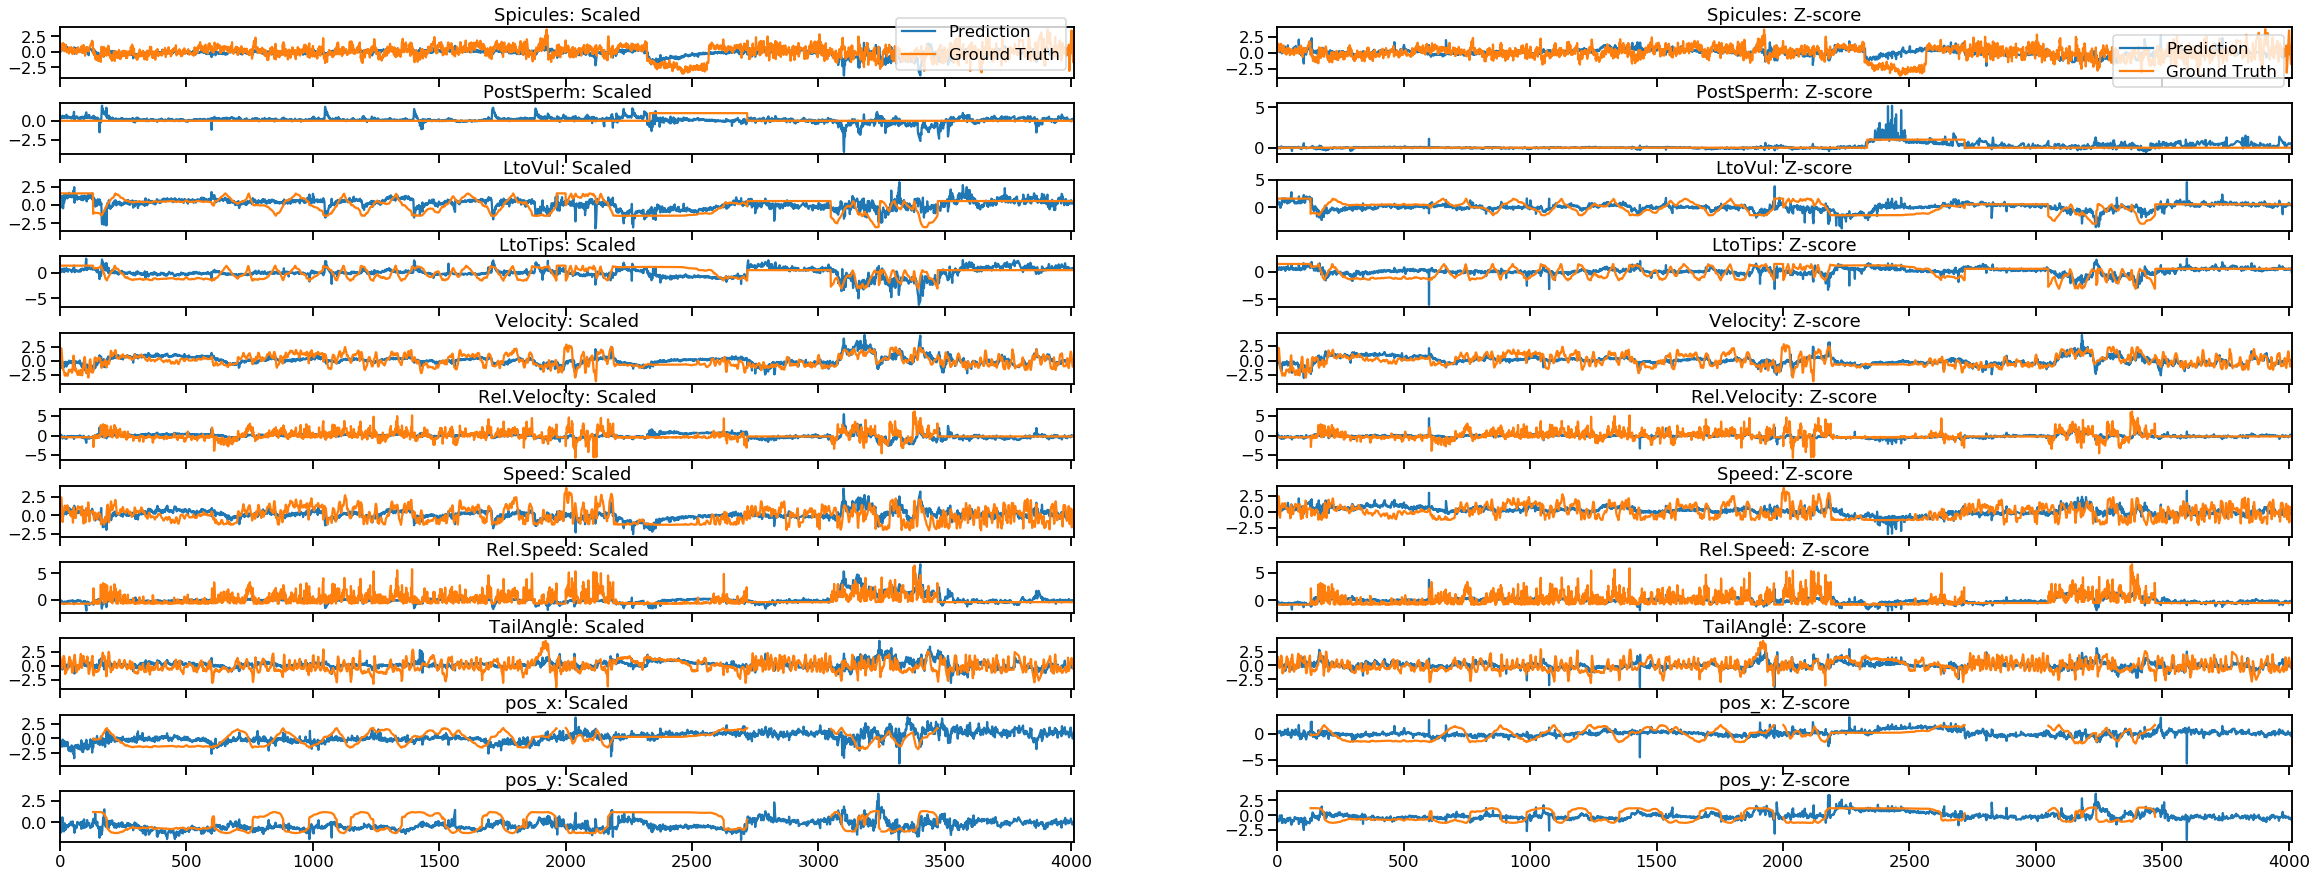

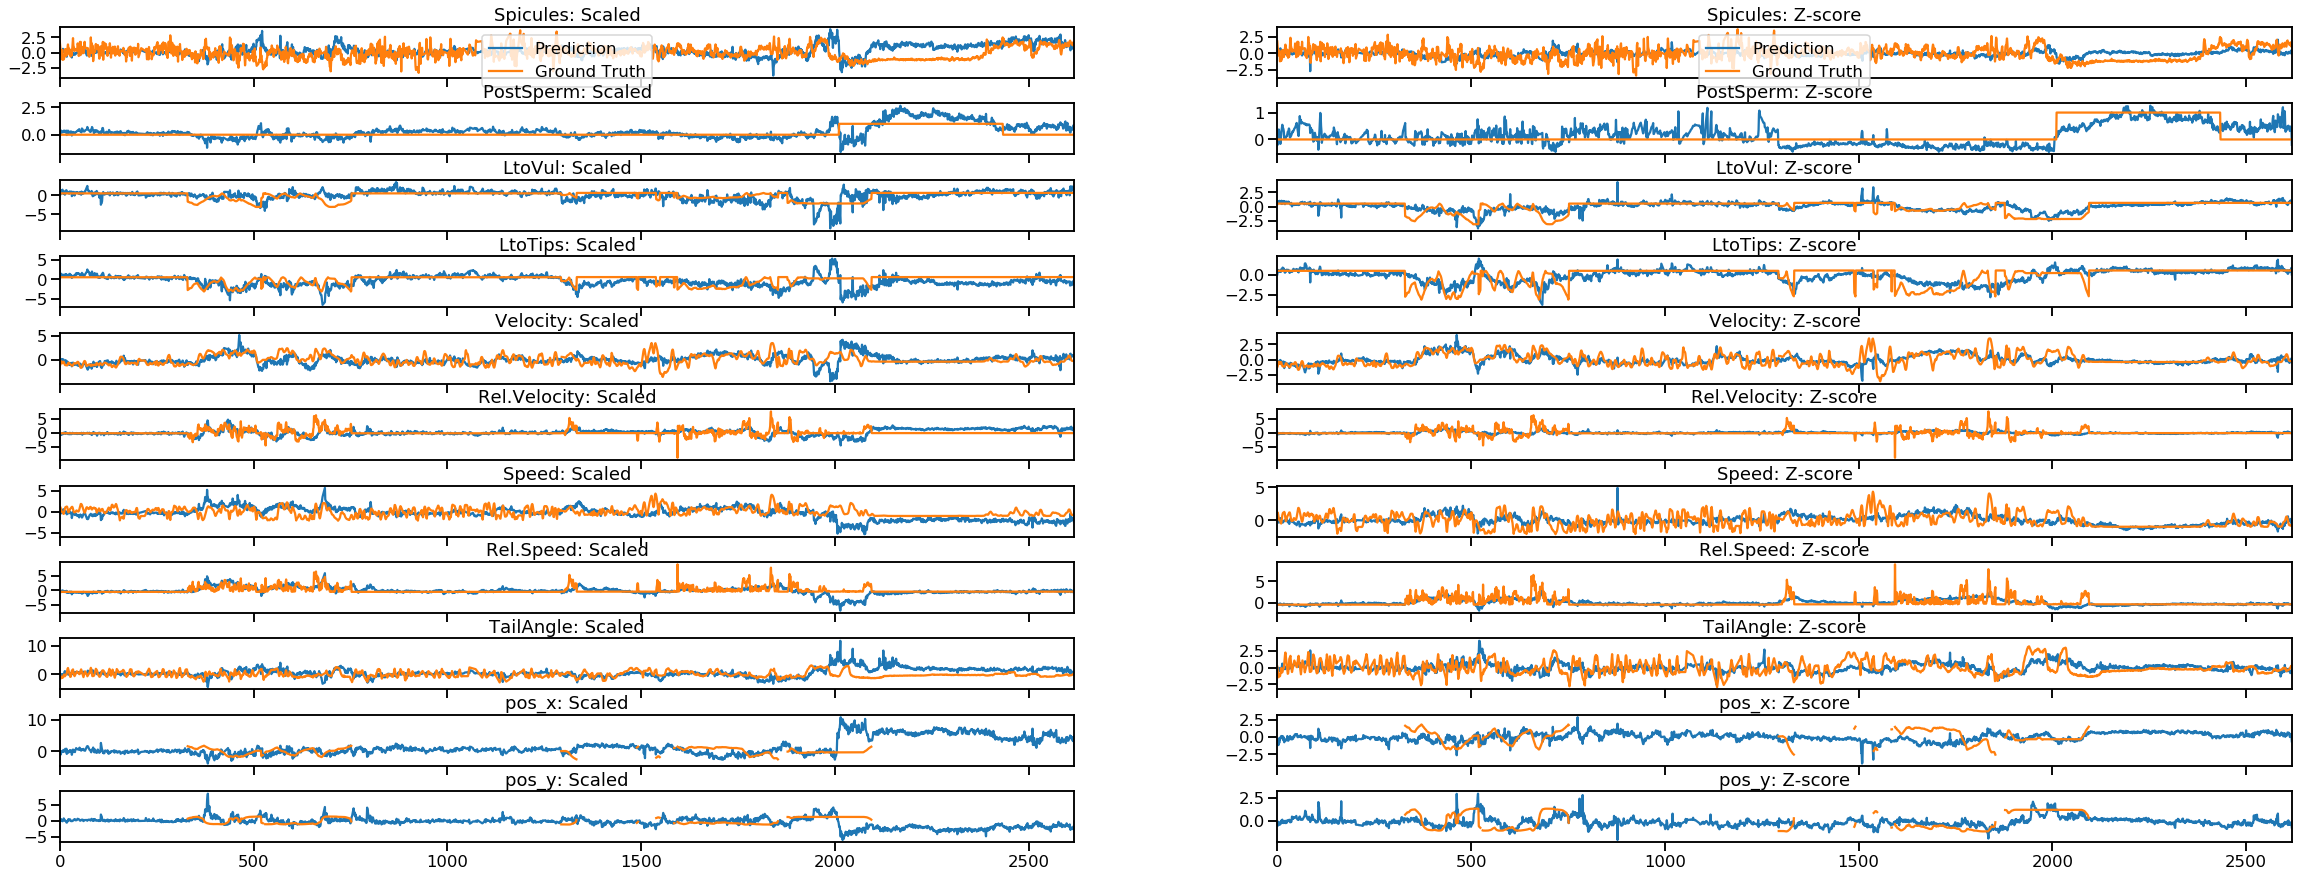

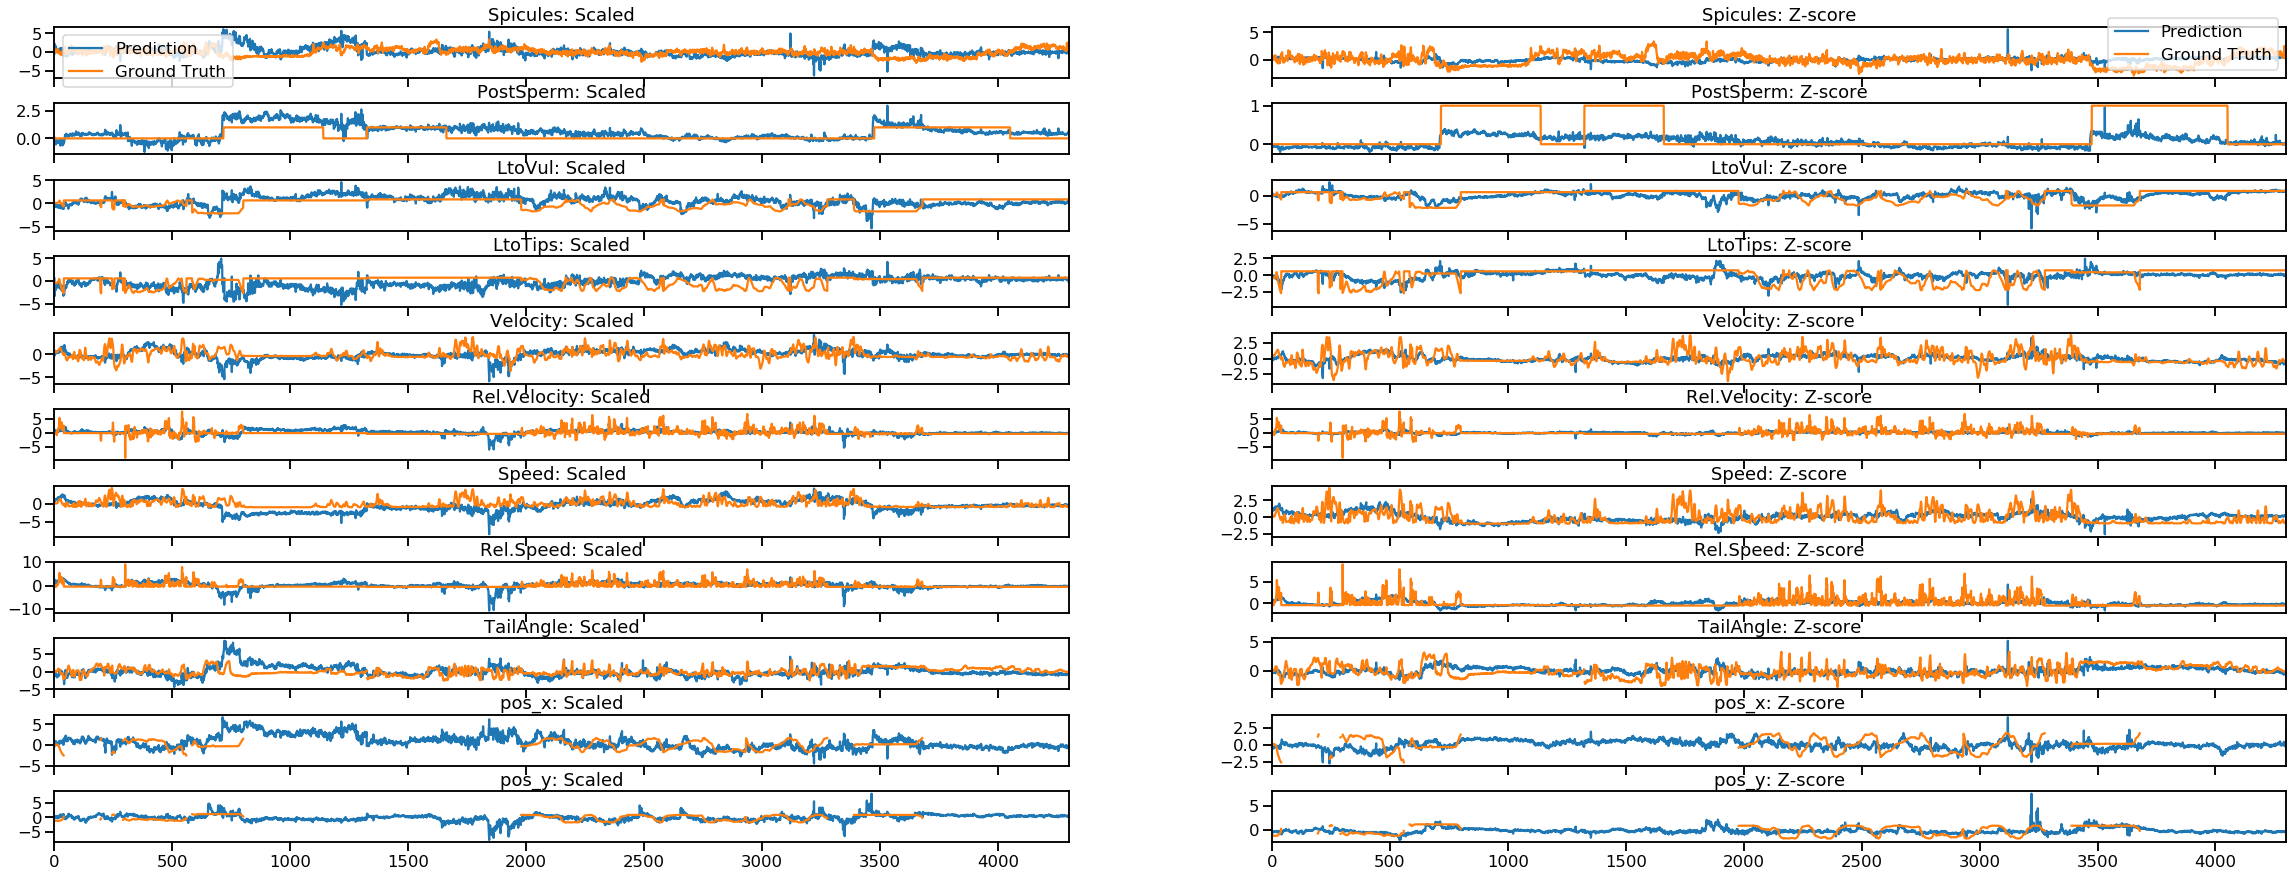

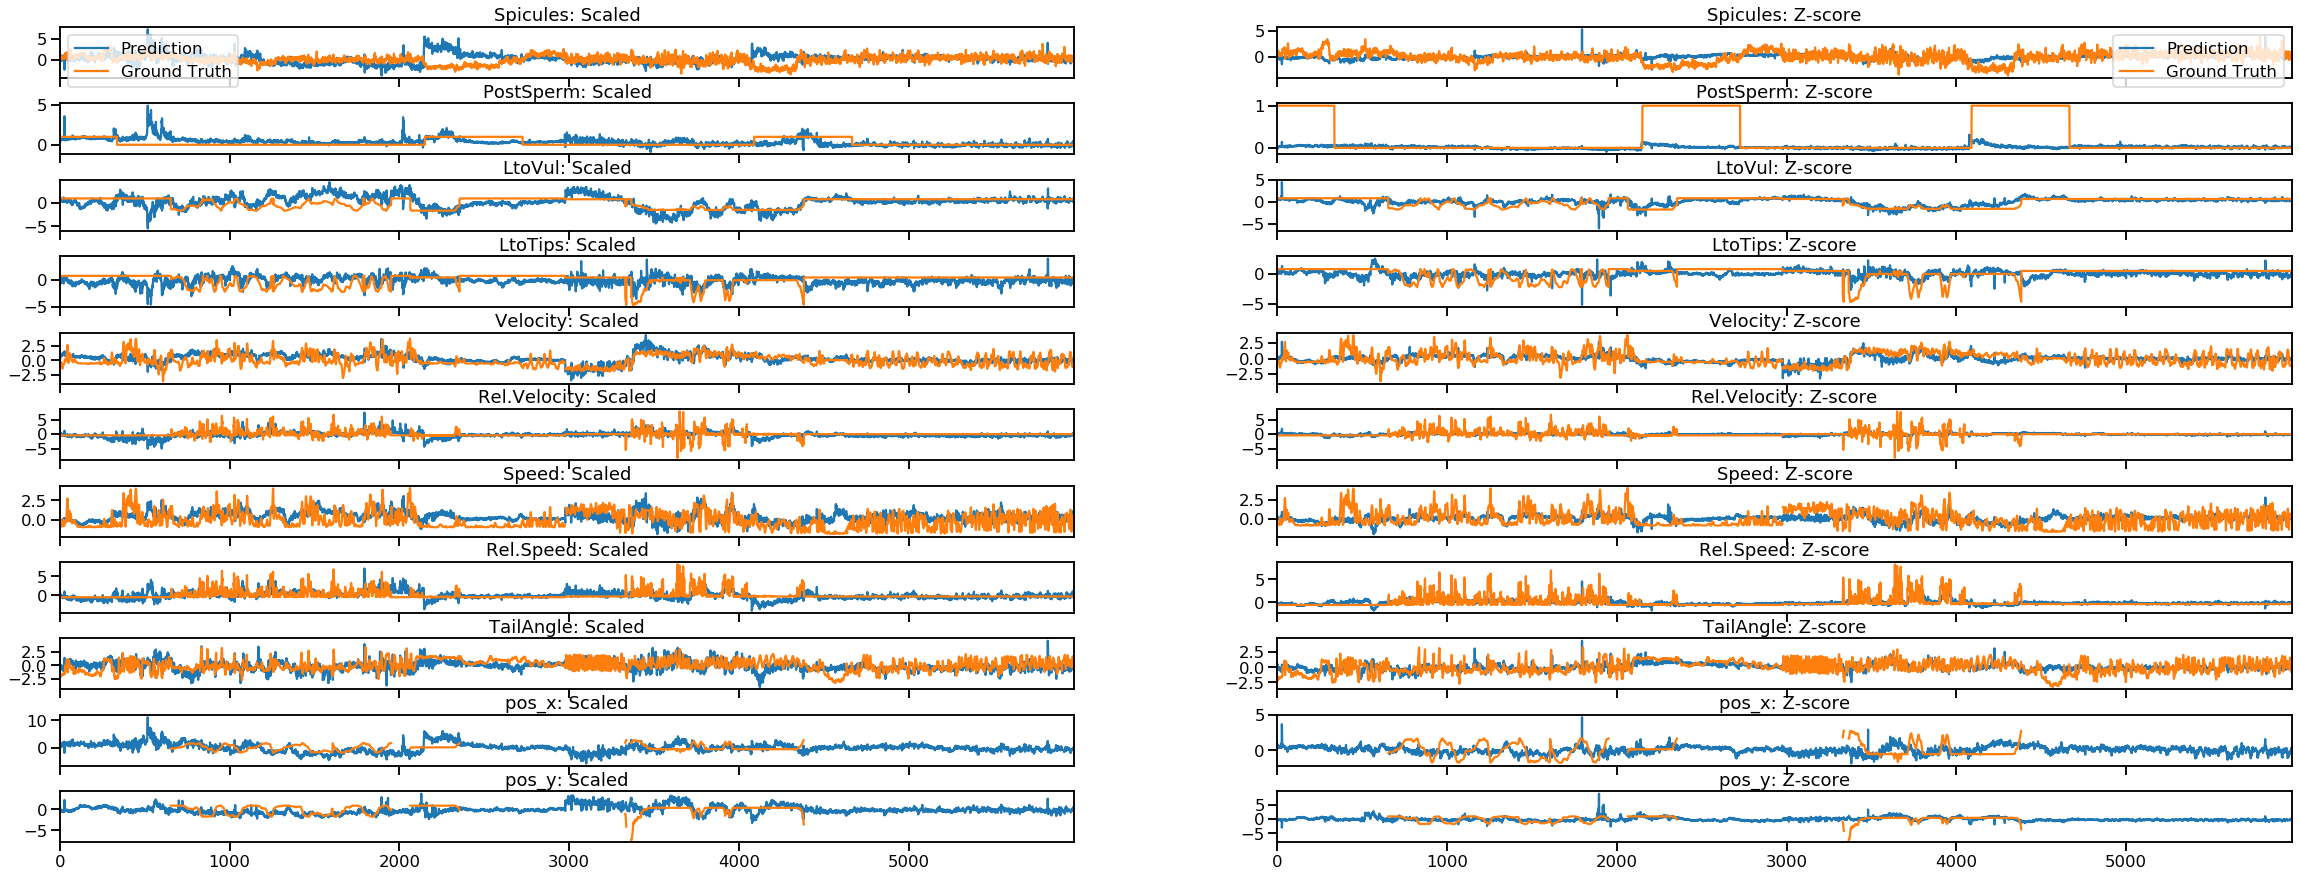

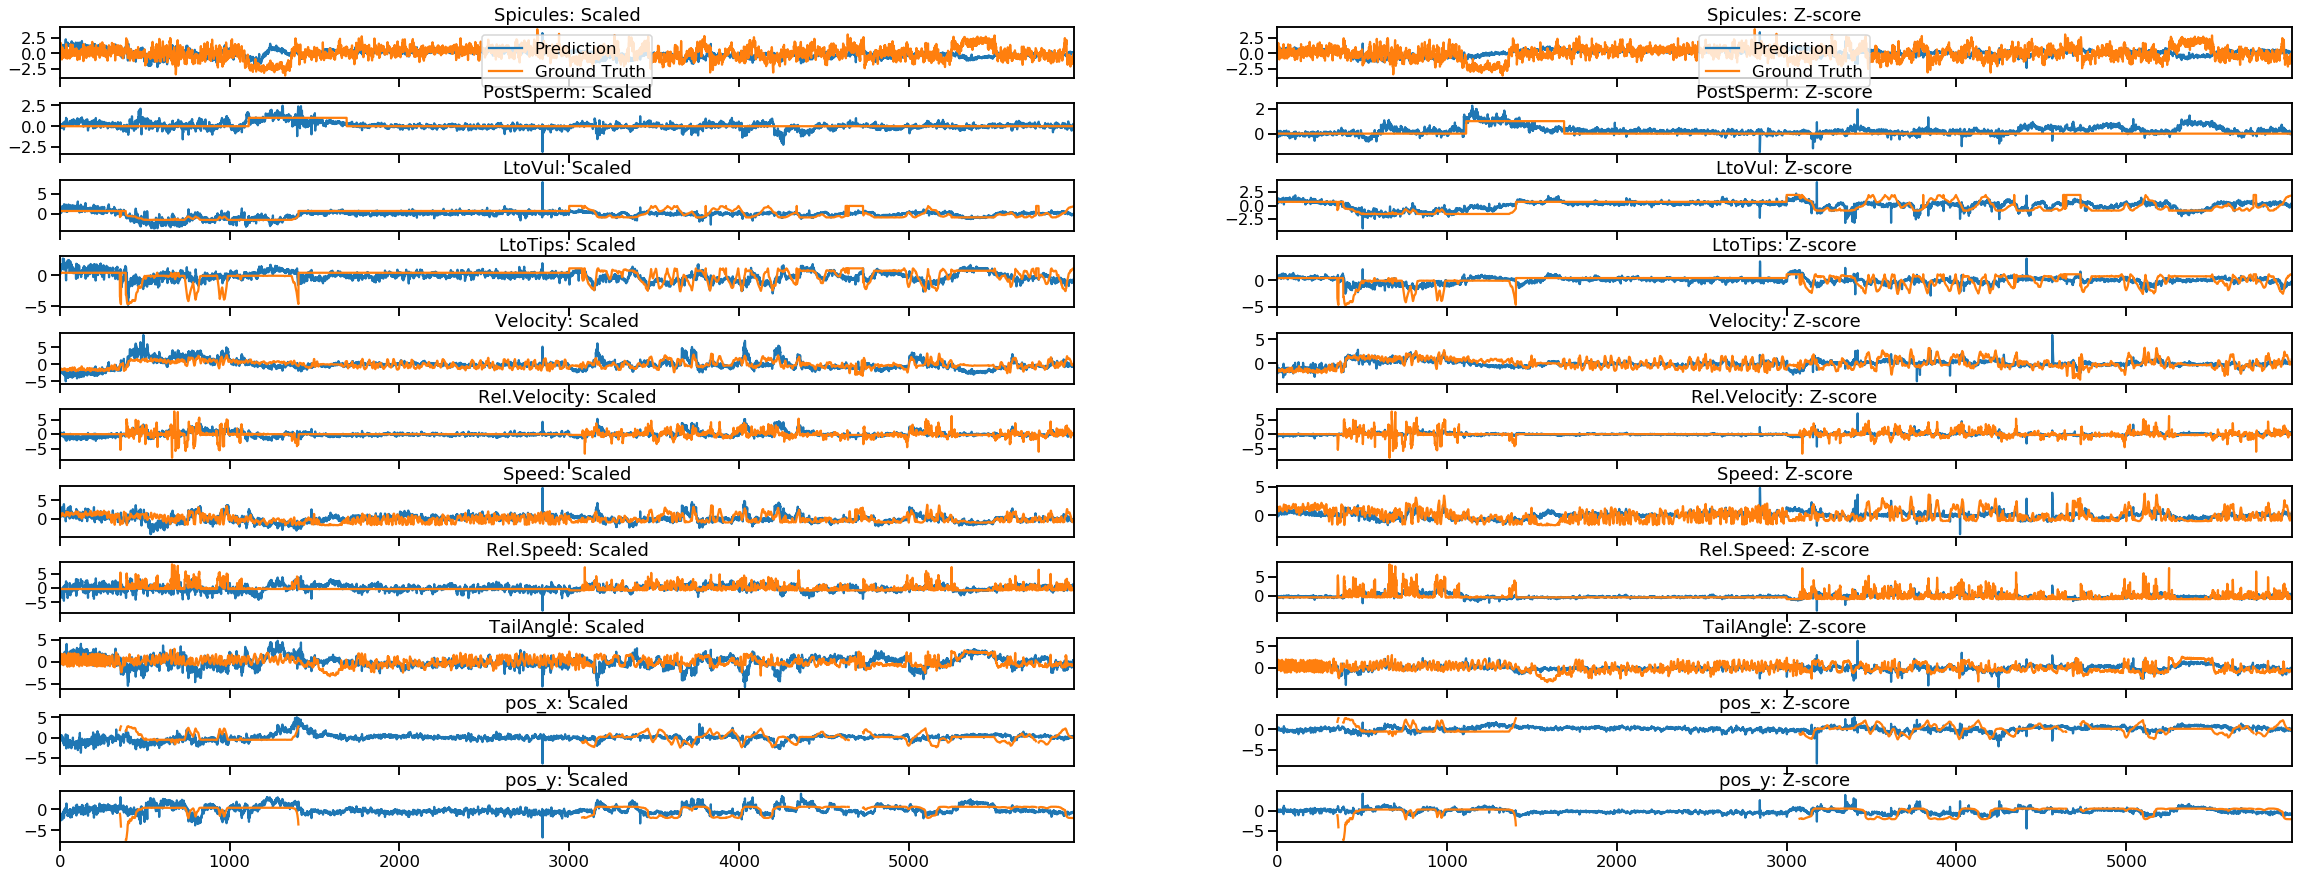

In [9]:
for i in range(5):    
    predict_df = prediction_list[i]
    groundtruth_df = groundtruth_list[i]
    predict_df_z = prediction_list_z[i]
    groundtruth_df_z = groundtruth_list_z[i]
    grid_kws = {"hspace": 0.5}
    f,axes = plt.subplots(11,2,sharex=True,gridspec_kw = grid_kws, figsize=(40,15))
    axes[0,0].set_title('Linear Network that accounts for missing data. Input Scaling Trained separately for each worm. Trained on first 5 worms and tested on last 2.')
    predict_df[['Spicules']].plot(ax=axes[0,0], title = 'Spicules: Scaled')
    groundtruth_df[['Spicules']].plot(ax=axes[0,0])
    axes[0,0].legend(['Prediction', 'Ground Truth'])
    predict_df[['PostSperm']].plot(ax=axes[1,0], title = 'PostSperm: Scaled')
    groundtruth_df[['PostSperm']].plot(ax=axes[1,0])
    axes[1,0].get_legend().remove()
    #axes[1,0].legend(['Prediction', 'Ground Truth'])
    predict_df[['LtoVul']].plot(ax=axes[2,0], title = 'LtoVul: Scaled')
    groundtruth_df[['LtoVul']].plot(ax=axes[2,0])
    axes[2,0].get_legend().remove()
    #axes[2,0].legend(['Prediction', 'Ground Truth'])
    predict_df[['LtoTips']].plot(ax=axes[3,0], title = 'LtoTips: Scaled')
    groundtruth_df[['LtoTips']].plot(ax=axes[3,0])
    axes[3,0].get_legend().remove()
    #axes[3,0].legend(['Prediction', 'Ground Truth'])
    predict_df[['Velocity']].plot(ax=axes[4,0], title = 'Velocity: Scaled')
    groundtruth_df[['Velocity']].plot(ax=axes[4,0])
    axes[4,0].get_legend().remove()
    #axes[4,0].legend(['Prediction', 'Ground Truth'])
    predict_df[['Rel.Velocity']].plot(ax=axes[5,0], title = 'Rel.Velocity: Scaled')
    groundtruth_df[['Rel.Velocity']].plot(ax=axes[5,0])
    axes[5,0].get_legend().remove()
    #axes[5,0].legend(['Prediction', 'Ground Truth'])
    predict_df[['Speed']].plot(ax=axes[6,0], title = 'Speed: Scaled')
    groundtruth_df[['Speed']].plot(ax=axes[6,0])
    axes[6,0].get_legend().remove()
    #axes[6,0].legend(['Prediction', 'Ground Truth'])
    predict_df[['Rel.Speed']].plot(ax=axes[7,0], title = 'Rel.Speed: Scaled')
    groundtruth_df[['Rel.Speed']].plot(ax=axes[7,0])
    axes[7,0].get_legend().remove()
    #axes[7,0].legend(['Prediction', 'Ground Truth'])
    predict_df[['TailAngle']].plot(ax=axes[8,0], title = 'TailAngle: Scaled')
    groundtruth_df[['TailAngle']].plot(ax=axes[8,0])
    axes[8,0].get_legend().remove()
    #axes[8,0].legend(['Prediction', 'Ground Truth'])
    predict_df[['pos_x']].plot(ax=axes[9,0], title = 'pos_x: Scaled')
    groundtruth_df[['pos_x']].plot(ax=axes[9,0])
    axes[9,0].get_legend().remove()
    #axes[9,0].legend(['Prediction', 'Ground Truth'])
    predict_df[['pos_y']].plot(ax=axes[10,0], title = 'pos_y: Scaled')
    groundtruth_df[['pos_y']].plot(ax=axes[10,0])
    axes[10,0].get_legend().remove()
    #axes[10,0].legend(['Prediction', 'Ground Truth'])
    axes[0,1].set_title('Linear Network that accounts for missing data. Input Scaling Trained separately for each worm. Trained on first 5 worms and tested on last 2.')
    predict_df_z[['Spicules']].plot(ax=axes[0,1], title = 'Spicules: Z-score')
    groundtruth_df_z[['Spicules']].plot(ax=axes[0,1])
    axes[0,1].legend(['Prediction', 'Ground Truth'])
    predict_df_z[['PostSperm']].plot(ax=axes[1,1], title = 'PostSperm: Z-score')
    groundtruth_df_z[['PostSperm']].plot(ax=axes[1,1])
    axes[1,1].get_legend().remove()
    #axes[1,1].legend(['Prediction', 'Ground Truth'])
    predict_df_z[['LtoVul']].plot(ax=axes[2,1], title = 'LtoVul: Z-score')
    groundtruth_df_z[['LtoVul']].plot(ax=axes[2,1])
    axes[2,1].get_legend().remove()
    #axes[2,1].legend(['Prediction', 'Ground Truth'])
    predict_df_z[['LtoTips']].plot(ax=axes[3,1], title = 'LtoTips: Z-score')
    groundtruth_df_z[['LtoTips']].plot(ax=axes[3,1])
    axes[3,1].get_legend().remove()
    #axes[3,1].legend(['Prediction', 'Ground Truth'])
    predict_df_z[['Velocity']].plot(ax=axes[4,1], title = 'Velocity: Z-score')
    groundtruth_df_z[['Velocity']].plot(ax=axes[4,1])
    axes[4,1].get_legend().remove()
    #axes[4,1].legend(['Prediction', 'Ground Truth'])
    predict_df_z[['Rel.Velocity']].plot(ax=axes[5,1], title = 'Rel.Velocity: Z-score')
    groundtruth_df_z[['Rel.Velocity']].plot(ax=axes[5,1])
    axes[5,1].get_legend().remove()
    #axes[5,1].legend(['Prediction', 'Ground Truth'])
    predict_df_z[['Speed']].plot(ax=axes[6,1], title = 'Speed: Z-score')
    groundtruth_df_z[['Speed']].plot(ax=axes[6,1])
    axes[6,1].get_legend().remove()
    #axes[6,1].legend(['Prediction', 'Ground Truth'])
    predict_df_z[['Rel.Speed']].plot(ax=axes[7,1], title = 'Rel.Speed: Z-score')
    groundtruth_df_z[['Rel.Speed']].plot(ax=axes[7,1])
    axes[7,1].get_legend().remove()
    #axes[7,1].legend(['Prediction', 'Ground Truth'])
    predict_df_z[['TailAngle']].plot(ax=axes[8,1], title = 'TailAngle: Z-score')
    groundtruth_df_z[['TailAngle']].plot(ax=axes[8,1])
    axes[8,1].get_legend().remove()
    #axes[8,1].legend(['Prediction', 'Ground Truth'])
    predict_df_z[['pos_x']].plot(ax=axes[9,1], title = 'pos_x: Z-score')
    groundtruth_df_z[['pos_x']].plot(ax=axes[9,1])
    axes[9,1].get_legend().remove()
    #axes[9,1].legend(['Prediction', 'Ground Truth'])
    predict_df_z[['pos_y']].plot(ax=axes[10,1], title = 'pos_y: Z-score')
    groundtruth_df_z[['pos_y']].plot(ax=axes[10,1])
    axes[10,1].get_legend().remove()
    #axes[10,1].legend(['Prediction', 'Ground Truth'])